# examp_oce_layers: Isopycnal transport in ICON

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyicon as pyic
import xarray as xr
import cartopy.crs as ccrs
import cmocean
from scipy.interpolate import interp1d
import regionmask

----Start loading pyicon.
----Start loading pyicon.
----Pyicon was loaded successfully.
----Pyicon was loaded successfully.


## Preparing data and grid

In [3]:
# run = 'nib0003_lay'
# path_data = f'/work/mh0033/m300602/proj_vmix/icon/icon_23/icon-oes-trr181-layers/experiments/{run}/'
# # tstr = '*'

run = 'nib2334'
path_data = f'/work/mh0033/m300602/proj_vmix/icon/icon_23/icon-oes-trr181-layers-02/experiments/{run}_c20/'
tstr = '20100101T000000Z'

# run = 'nib0001'
# path_data = f'/work/mh0033/m300602/proj_vmix/icon/icon_layers/feature-ocean-layers/experiments/{run}/'
# tstr = '*'

In [4]:
ds_lay = xr.open_mfdataset(f'{path_data}/{run}_P1Y_layers_{tstr}.nc')
ds_lay = ds_lay.rename(ncells_2='cell', ncells='edge')
ds_lay = ds_lay.isel(time=-1)
# ds_lay = ds_lay.isel(time=slice(-5,None)).mean(dim='time')

In [5]:
%%time
ds_lay = ds_lay.compute()

CPU times: user 220 ms, sys: 427 ms, total: 647 ms
Wall time: 761 ms


In [6]:
ds_lay

<xarray.Dataset>
Dimensions:             (edge: 356545, vertices: 4, cell: 235403,
                         vertices_2: 3, lev: 84, lev_2: 85, depth: 64)
Coordinates:
    elon                (edge) float32 1.282 1.274 1.266 ... 1.34 1.343 1.337
    elat                (edge) float32 1.267 1.271 1.267 ... -0.7901 -0.7902
    clon                (cell) float32 1.274 1.274 1.341 ... 1.34 1.347 1.334
    clat                (cell) float32 1.269 1.273 1.268 ... -0.7912 -0.7916
  * lev                 (lev) float64 15.0 30.5 31.5 32.5 ... 37.19 37.2 39.6
  * lev_2               (lev_2) float64 0.0 30.0 31.0 32.0 ... 37.2 37.2 42.0
  * depth               (depth) float64 6.0 17.0 27.0 ... 5.334e+03 5.589e+03
    time                datetime64[ns] 2010-01-01
Dimensions without coordinates: edge, vertices, cell, vertices_2
Data variables: (12/17)
    elon_bnds           (edge, vertices) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    elat_bnds           (edge, vertices) float32 1.264 0.0 ... -0.7861 -0.7889
    clon_bnds           (cell, vertices_2) float32 1.291 1.257 ... 1.327 1.333
    clat_bnds           (cell, vertices_2) float32 1.271 1.271 ... -0.7861
    mass_flux_lay       (lev, edge) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    layer_thickness_e   (lev, edge) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                  ...
    diapycnal_velocity  (lev_2, cell) float32 0.0 -7.672e-08 0.0 ... 0.0 0.0 0.0
    sigma2              (depth, cell) float32 0.0 32.64 0.0 ... 0.0 0.0 0.0
    sflx_dens           (cell) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    alphaT              (cell) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    betaS               (cell) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    weight_e_sum        (depth, edge) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          f4ed57f6-b2ea-11e9-ae92-c52a3fa37d96
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-oes.git@aaeb340bb446f1...
    history:              ./icon at 20231210 031515
    references:           see MPIM/DWD publications
    comment:              Nils Brüggemann (m300602) on l10336 (Linux 4.18.0-3...

In [7]:
# # for R2B4
# ds_fx = xr.open_dataset('/work/mh0033/m300602/icon/grids/r2b4_oce_r0004/r2b4_oce_r0004_L40_fx.nc')
# ds_fx = ds_fx.rename(ncells='cell', ncells_2='edge', depth='depthc', depth_2='depthi')
# ds_tg = xr.open_dataset('/work/mh0033/m300602/icon/grids/r2b4_oce_r0004/r2b4_oce_r0004_tgrid.nc')

# for R2B6
ds_fx = xr.open_dataset('/work/mh0033/m300602/icon/grids/r2b6_oce_r0004/r2b6_oce_r0004_L64_fx.nc')
ds_fx = ds_fx.rename(ncells='cell', ncells_2='edge', depth='depthc', depth_2='depthi')
ds_tg = xr.open_dataset('/work/mh0033/m300602/icon/grids/r2b6_oce_r0004/r2b6_oce_r0004_tgrid.nc')

In [8]:
ds_IcD = pyic.convert_tgrid_data(ds_tg)

In [9]:
# all variables from layer package
list(ds_lay)

['elon_bnds',
 'elat_bnds',
 'clon_bnds',
 'clat_bnds',
 'mass_flux_lay',
 'layer_thickness_e',
 'layer_thickness_c',
 'dhdt_tot',
 'dhdt_srf',
 'dhdt_hfl',
 'div_mass_flux_lay',
 'diapycnal_velocity',
 'sigma2',
 'sflx_dens',
 'alphaT',
 'betaS',
 'weight_e_sum']

In [11]:
# some isopycnal levels and corresponding indices for plotting
isos = [36.85, 36.92, 36.96, 37.0]
for kk, iso in enumerate(isos):
    kiso = np.argmin((ds_lay.lev_2.data-iso)**2)
    print(ds_lay.lev_2.data[kiso])

36.84
36.92
36.96
37.0


In [ ]:
rho_lev = ds_lay.lev_2.data
layer_thickness_e = ds_lay.layer_thickness_e.compute()

## Diapycnal velocities from isopycnal flow (optional)

This analysis is optional since ICON can write out the diapycnal velocity directly.

In [12]:
div_coeff = pyic.xr_calc_div_coeff(ds_IcD)
div_mass_flux_lay = pyic.xr_calc_div(ds_IcD, ds_lay.mass_flux_lay, div_coeff)

In [13]:
da = -div_mass_flux_lay[::-1,:].cumsum(dim='lev')[::-1,:]
diapycnal_velocity = xr.DataArray(np.zeros(ds_lay.diapycnal_velocity.shape), coords=ds_lay.diapycnal_velocity.coords)
diapycnal_velocity[:-1,:] = da[:,:]

Check if calculation is correct

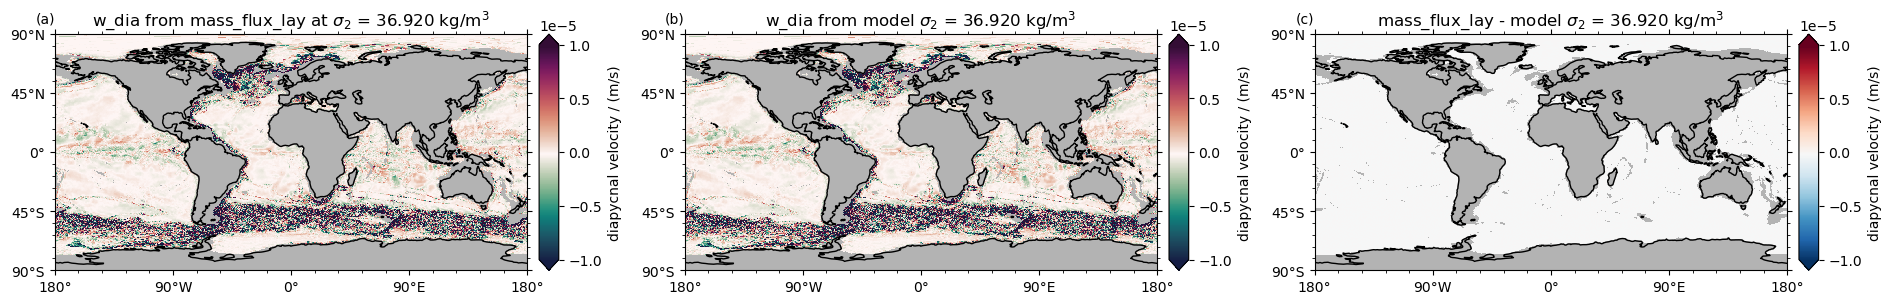

In [14]:
P = pyic.Plot(3, 1, plot_cb=True, projection=ccrs.PlateCarree())

iso = isos[1]
kiso = np.argmin((ds_lay.lev_2.data-iso)**2)

ax, cax = P.next()
P.plot(diapycnal_velocity.isel(lev_2=kiso), clim=10e-6, cmap=cmocean.cm.curl)
ax.set_title(f'w_dia from mass_flux_lay at $\sigma_2$ = %.3f kg/m$^3$' % (iso))

ax, cax = P.next()
P.plot(ds_lay.diapycnal_velocity.isel(lev_2=kiso), clim=10e-6, cmap=cmocean.cm.curl)
ax.set_title(f'w_dia from model $\sigma_2$ = %.3f kg/m$^3$' % (iso))

ax, cax = P.next()
P.plot(diapycnal_velocity.isel(lev_2=kiso) - ds_lay.diapycnal_velocity.isel(lev_2=kiso), clim=10e-6)
ax.set_title(f'mass_flux_lay - model $\sigma_2$ = %.3f kg/m$^3$' % (iso))

for ax, cax in zip(P.hca, P.hcb):
    ax.set_title('', loc='left')
    ax.set_title('', loc='right')
    cax.set_ylabel('diapycnal velocity / (m/s)')

## Diapycnal velocities

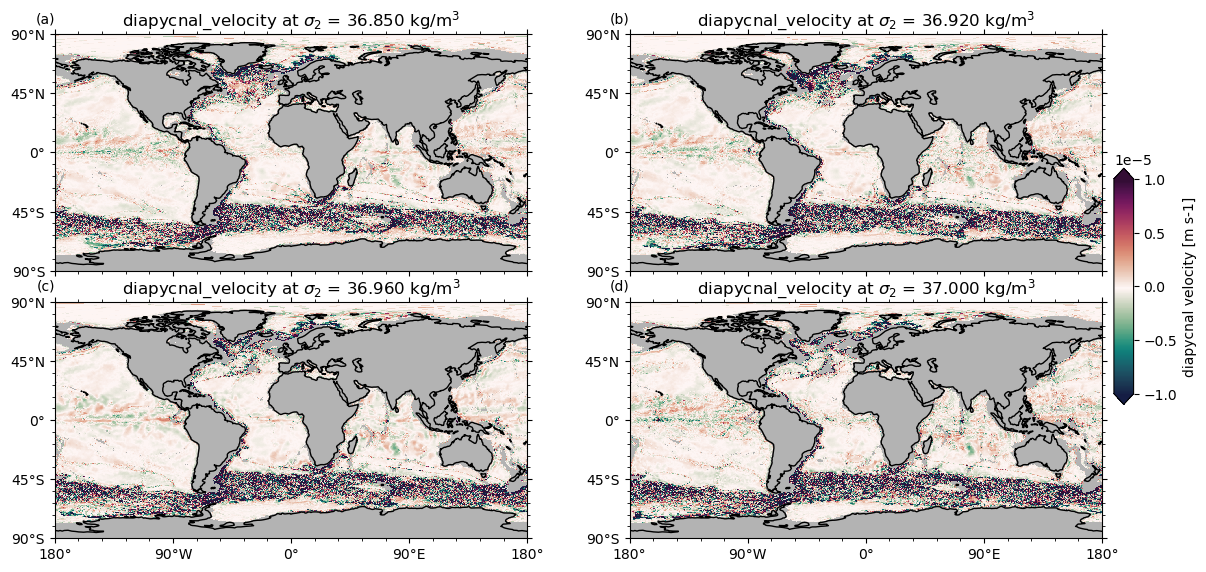

In [30]:
P = pyic.Plot(2, 2, plot_cb='right', projection=ccrs.PlateCarree())

for kk, iso in enumerate(isos):
    ax, cax = P.next()
    kiso = np.argmin((ds_lay.lev_2.data-iso)**2)

    da = ds_lay['diapycnal_velocity'].isel(lev_2=kiso).compute()
    P.plot(da, clim=10e-6, cmap=cmocean.cm.curl)
    ax.set_title(f'diapycnal_velocity at $\sigma_2$ = %.3f kg/m$^3$' % (iso))
    ax.set_title('', loc='left')
    ax.set_title('', loc='right')

## Isopycnal MOC

In [15]:
# makes a nice plot of isopycnal streamfunction in density space
def plot_dmoc(dmoc, rho_lev, clim=None, norm=None, contfs=None, conts=None, cbticks=None, ax=0, cax=0):
    fac = 1.
    remap_d2r=np.hstack([0.00, 
                         np.arange(30.00, 35.99, 1.00/fac),
                         np.arange(36.00, 36.64, 0.20/fac),# 0.15
                         np.arange(36.65, 36.91, 0.05/fac),
                         np.arange(36.92, 37.04, 0.02/fac),
                         np.arange(37.05, 38.50, 0.25/fac),
                         44.00])
    remap_d2r = np.sort(np.unique(remap_d2r))
    remap_d2r_major = np.array([30.00, 36.00, 36.65, 36.92, 37.05])
    reg      = np.linspace(0, len(remap_d2r), len(remap_d2r))
    reg      = reg[::-1]
    dens2reg = interp1d(remap_d2r, reg      , kind='linear')
    reg2dens = interp1d(reg      , remap_d2r, kind='linear')
    
    reg_lev = dens2reg(rho_lev)

    # hm = pyic.shade(lat_mg, reg_lev, dmoc/1e6, ax=ax, cax=cax, clim=clevs[-1], conts=conts)
    hm = pyic.shade(lat_mg, reg_lev, dmoc/1e6, ax=ax, cax=cax, clim=clim, norm=norm, contfs=contfs, conts=conts, cmap=cmocean.cm.curl, cbticks=cbticks)
    # hm = pyic.shade(lat_mg, reg_lev, dmoc/1e6, ax=ax, cax=cax, clim=clevs[-1], conts=clevs_sp, contcolor='k', use_pcol=False)
    # ax.clabel(hm[1], fontsize=8, fmt='%.1fSv')
    Cl = ax.clabel(hm[1], colors='k', fontsize=8, fmt='%.1f Sv', inline=True)
    # for txt in Cl:
    #   txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0))

    xy, x_ind, y_ind = np.intersect1d(remap_d2r, remap_d2r_major, return_indices=True)
    # --> this will become major tick marks (larger fontsize)
    ymajorticks = reg[x_ind] 
    ax.set_yticks( ymajorticks, minor=False ) 

    ymajorlabel_list = np.around(reg2dens(ymajorticks), 3).tolist()
    ylabelmayjor_list_fmt=list()
    for num in ymajorlabel_list: ylabelmayjor_list_fmt.append('{:2.2f}'.format(num))
    ax.set_yticklabels(ylabelmayjor_list_fmt, minor=False, size = 10)

    # --> this will become minor tick marks (smaller fontsize)
    yminorticks = np.setdiff1d(reg[1:-1], ymajorticks)
    ax.set_yticks( yminorticks, minor=True )

    yminorlabel_list = np.around(reg2dens(yminorticks), 3).tolist()
    ylabelminor_list_fmt=list()
    for num in yminorlabel_list: ylabelminor_list_fmt.append('{:2.2f}'.format(num))
    ax.set_yticklabels(ylabelminor_list_fmt, minor=True, size = 6)
    
    ax.grid(True)
    return

In [21]:
# latitude bands for zonal average
clat = ds_IcD.clat
lat_group = np.round(clat/0.3)*0.3

In [22]:
# derive global MOC, Atlantic MOC and Indo-Pacific MOC in density space
wdTransp = ds_lay['diapycnal_velocity']*ds_IcD.cell_area
wdTransp = wdTransp.compute()
wdTransp = wdTransp.where(np.isfinite(wdTransp))

gmoc_d = -(wdTransp.groupby(lat_group).sum())[:,::-1].cumsum(dim='clat')[:,::-1]
amoc_d = -(wdTransp.where(ds_fx.basin_c==1.).groupby(lat_group).sum())[:,::-1].cumsum(dim='clat')[:,::-1]
ipsomoc_d = -(wdTransp.where((ds_fx.basin_c==3.) | (ds_fx.basin_c==7.)).groupby(lat_group).sum())[:,::-1].cumsum(dim='clat')[:,::-1]
lat_mg = gmoc_d.clat

Text(0.5, 1.0, 'Indo-Pacific isopycnal streamfunction / Sv')

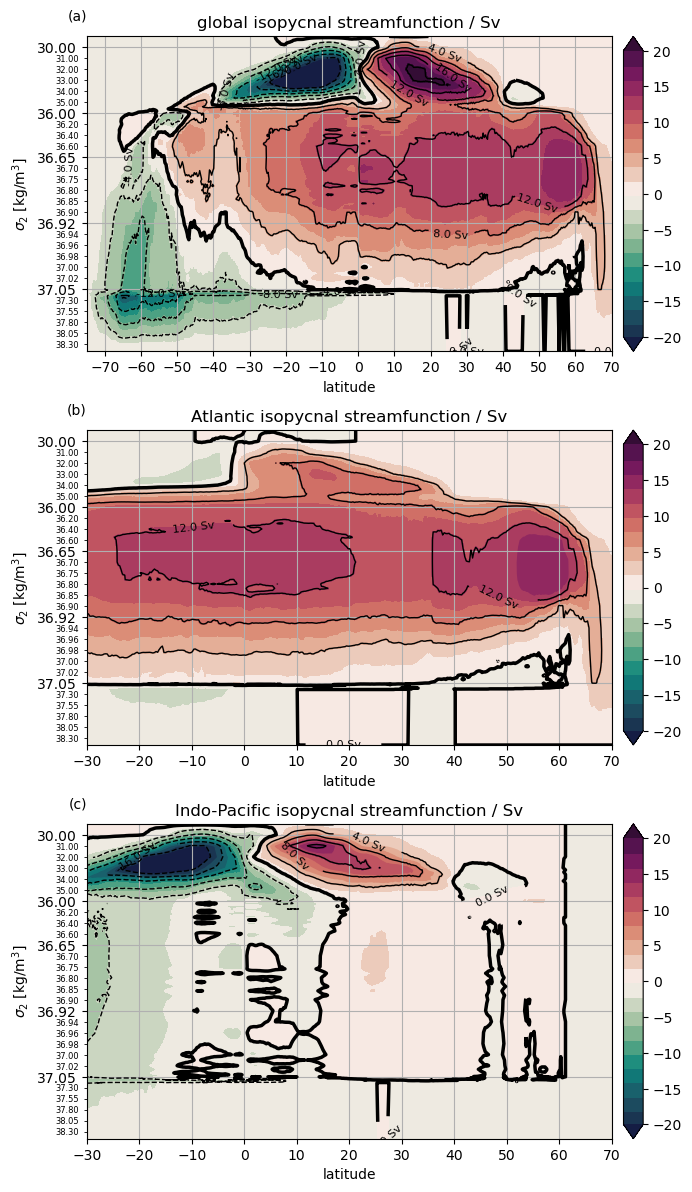

In [23]:
P = pyic.Plot(1, 3, asp=0.6, fig_size_fac=2, sharex=False, xlabel='latitude', ylabel='$\sigma_2$ [kg/m$^3$]')

clim = 20
contfs = np.arange(-clim, clim+1, 2)
conts = np.arange(-clim, clim+5, 4)
cbticks = np.arange(-20,21,5)

ax, cax = P.next()
plot_dmoc(gmoc_d, rho_lev, ax=ax, cax=cax, clim=clim, contfs=contfs, conts=conts, cbticks=cbticks)
ax.set_xticks(np.arange(-90,100,10))
ax.set_xlim(-75,70)
ax.set_title('global isopycnal streamfunction / Sv')

ax, cax = P.next()
plot_dmoc(amoc_d, rho_lev, ax=ax, cax=cax, clim=clim, contfs=contfs, conts=conts, cbticks=cbticks)
ax.set_xticks(np.arange(-90,100,10))
ax.set_xlim(-30,70)
ax.set_title('Atlantic isopycnal streamfunction / Sv')

ax, cax = P.next()
plot_dmoc(ipsomoc_d, rho_lev, ax=ax, cax=cax, clim=clim, contfs=contfs, conts=conts, cbticks=cbticks)
ax.set_xticks(np.arange(-90,100,10))
ax.set_xlim(-30,70)
ax.set_title('Indo-Pacific isopycnal streamfunction / Sv')

## Isopycnal MOC remapped to depth levels

In [24]:
# to remap isopycnal streamfunction from density space to depth space
def remap_isop_moc(gmoc_d, amoc_d, ipsomoc_d, lay_thick_e, ds_IcD, depthi):   
    # lay_thick_e = ds_lay.layer_thickness_e.compute()
    depth_lay_e = lay_thick_e.cumsum(dim='lev')
    depth_lay_e = depth_lay_e.where(lay_thick_e!=0.)
    
    # lay_thick_c = ds_lay.layer_thickness_c.compute()
    # depth_lay_c = lay_thick_c.cumsum(dim='lev')
    # depth_lay_c = depth_lay_c.where(lay_thick_c!=0.)
    depth_lay_c = depth_lay_e.isel(edge=ds_IcD.edge_of_cell).mean(dim='ne_c')
    depth_lay_c = depth_lay_c
    
    # --- filter Mediteranean from density layers
    if False:
        region = regionmask.defined_regions.ar6.ocean
        region_mask = region.mask(ds_IcD, lon_name='clon', lat_name='clat', wrap_lon=False)
        depth_lay_c = depth_lay_c.where(region_mask!=19)
    
    clat = ds_IcD.clat
    lat_group = np.round(clat/0.3)*0.3

    depth_lay_c_gzave = depth_lay_c.groupby(lat_group).mean()
    depth_lay_c_azave = depth_lay_c.where(ds_fx.basin_c==1.).groupby(lat_group).mean()
    depth_lay_c_ipzave = depth_lay_c.where((ds_fx.basin_c==3.) | (ds_fx.basin_c==7.)).groupby(lat_group).mean()
    lat_zave = depth_lay_c_gzave.clat
    
    depth_target = depthi
    # depth_target = np.linspace(0,depthi.max(),200)

    gmoc_dz = np.ma.zeros((depth_target.size, lat_zave.size))
    amoc_dz = np.ma.zeros((depth_target.size, lat_zave.size))
    ipmoc_dz = np.ma.zeros((depth_target.size, lat_zave.size))
    for jj in range(lat_zave.size):
        f = interp1d(depth_lay_c_gzave[:,jj], gmoc_d[1:,jj], bounds_error=False)
        gmoc_dz[:,jj] = f(depth_target)

        f = interp1d(depth_lay_c_azave[:,jj], amoc_d[1:,jj], bounds_error=False)
        amoc_dz[:,jj] = f(depth_target)

        f = interp1d(depth_lay_c_ipzave[:,jj], ipsomoc_d[1:,jj], bounds_error=False)
        ipmoc_dz[:,jj] = f(depth_target)
        
    lat = lat_mg
    return lat, gmoc_dz, amoc_dz, ipmoc_dz

In [25]:
depthi = ds_fx.depthi.data
lat, gmoc_dz, amoc_dz, ipmoc_dz = remap_isop_moc(gmoc_d, amoc_d, ipsomoc_d, layer_thickness_e, ds_IcD, depthi=depthi)

In [26]:
# derive maximum depth for masking remapped streamfunction
topo = (ds_fx.wet_c*ds_fx.prism_thick_c).sum(dim='depthc')

topo_gzave = topo.groupby(lat_group).mean()
topo_azave = topo.where(ds_fx.basin_c==1.).groupby(lat_group).mean()
topo_ipzave = topo.where((ds_fx.basin_c==3.) | (ds_fx.basin_c==7.)).groupby(lat_group).mean()

topo_gzmax = topo.groupby(lat_group).max()
topo_azmax = topo.where(ds_fx.basin_c==1.).groupby(lat_group).max()
topo_ipzmax = topo.where((ds_fx.basin_c==3.) | (ds_fx.basin_c==7.)).groupby(lat_group).max()

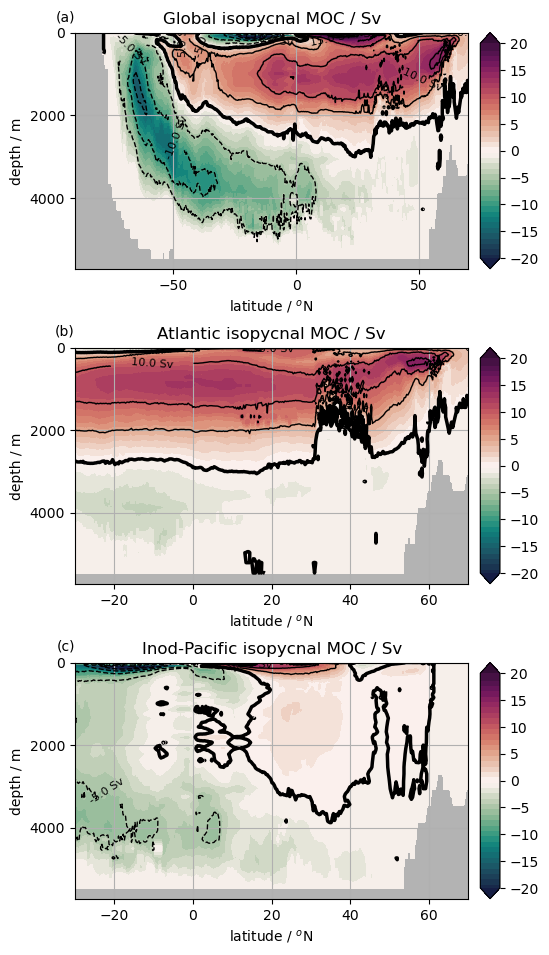

In [29]:
P = pyic.Plot(1, 3, asp=0.6, sharex=False, xlabel='latitude / $^o$N', ylabel='depth / m')

clim = 20
contfs = np.arange(-clim, clim+1, 1)
conts = np.arange(-clim, clim+5, 5)
cbticks = np.arange(-20,21,5)

ax, cax = P.next()
da = xr.DataArray(gmoc_dz/1e6, dims=['depth', 'clat'], coords=dict(depth=depthi, clat=lat))
da = da.where(da.isnull()==False,0)
da = da.where(da.depth<topo_gzmax)
hm = P.shade(lat, depthi, da, ax=ax, cax=cax, clim=clim, contfs=contfs, conts=conts, cmap=cmocean.cm.curl, cbticks=cbticks)
Cl = ax.clabel(hm[1], colors='k', fontsize=8, fmt='%.1f Sv', inline=True)
ax.set_title('Global isopycnal MOC / Sv')
ax.set_xlim(-90,70)

ax, cax = P.next()
da = xr.DataArray(amoc_dz/1e6, dims=['depth', 'clat'], coords=dict(depth=depthi, clat=lat))
da = da.where(da.isnull()==False,0)
da = da.where(da.depth<topo_gzmax)
hm = P.shade(lat, depthi, da, ax=ax, cax=cax, clim=clim, contfs=contfs, conts=conts, cmap=cmocean.cm.curl, cbticks=cbticks)
Cl = ax.clabel(hm[1], colors='k', fontsize=8, fmt='%.1f Sv', inline=True)
ax.set_title('Atlantic isopycnal MOC / Sv')
ax.set_xlim(-30,70)

ax, cax = P.next()
da = xr.DataArray(ipmoc_dz/1e6, dims=['depth', 'clat'], coords=dict(depth=depthi, clat=lat))
da = da.where(da.isnull()==False,0)
da = da.where(da.depth<topo_gzmax)
hm = P.shade(lat, depthi, da, ax=ax, cax=cax, clim=clim, contfs=contfs, conts=conts, cmap=cmocean.cm.curl, cbticks=cbticks)
Cl = ax.clabel(hm[1], colors='k', fontsize=8, fmt='%.1f Sv', inline=True)
ax.set_title('Inod-Pacific isopycnal MOC / Sv')
ax.set_xlim(-30,70)

for ax in P.hca:
    ax.invert_yaxis()
    ax.grid(True)
    ax.set_facecolor('0.7')